In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.initializers import lecun_uniform

from scripts_ml.ann_utils import *

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6385080904072001549
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1449056665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16070058512145789482
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-02-20_p180_bg_'
valid_code = '_val_24000_6000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1340'
postfix_time_seq = '_190824_1321'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = "RNN"+preproc_folder+valid_code.split('_val_')[1]+"_p180"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [4]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Flatten, GRU, BatchNormalization
from tensorflow.keras.models import Sequential

In [5]:
t = np.array([1,2,3,4])

In [6]:
fold = int(valid_code.split('_val_')[1].split('_')[0])

In [7]:
#recombining folds for grid search

val_X_tr = []
val_y_tr = []
val_X_tst = []
val_y_tst = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_tr.append(list(val_X_train[idx[0][-fold:]]))
    val_y_tr.append(list(val_y_train[idx[0][-fold:]]))
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_tst.append(list(val_X_test[test_idx]))
    val_y_tst.append(list(val_y_test[test_idx]))
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1

In [8]:
X = np.array(val_X_tr)
X=X.reshape((X.shape[1], X.shape[0], X.shape[2]))
#y = np.array([val_X_all[1]])


In [9]:
y = np.array(val_y_tr)
y = y.reshape((X.shape[0], X.shape[1],1))
y.shape

(24000, 3, 1)

In [10]:
X_val = np.array(val_X_tst)
X_val = X_val.reshape((X_val.shape[1], X_val.shape[0], X_val.shape[2]))

In [11]:
y_val = np.array(val_y_tst)
y_val = y_val.reshape((X_val.shape[0], X_val.shape[1],1))

In [12]:
from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(y_val),
#                                                 y_train)

cw = class_weight.compute_sample_weight({False:1, True:50},#'balanced',
                                                 #np.unique(y_train),
                                                 y_val.flatten())

In [13]:
#best
#model = Sequential()
#model.add(LSTM(40, return_sequences=True, dropout=0.4))
#model.add(LSTM(20, return_sequences=True,  activation='relu', dropout=0.4)) 
#model.add(LSTM(5, return_sequences=True, dropout=0.4))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])

In [14]:
batch_size=1024
shuffle = 'batch'
epochs = 1500
kernel_initializer = lecun_uniform(seed=42)
optimizer = tf.keras.optimizers.Adam()

In [15]:
#model = Sequential()
#model.add(LSTM(80, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=kernel_initializer))
#model.add(BatchNormalization())
#model.add(LSTM(40, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_initializer=kernel_initializer, activation='relu'))
#model.add(BatchNormalization())
#model.add(LSTM(25, return_sequences=True,  dropout=0.5, recurrent_dropout=0.5, kernel_initializer=kernel_initializer)) # recurrent_dropout=0.6, activation='relu')) dropout=0.6,
#model.add(BatchNormalization())
#model.add(LSTM(5, return_sequences=True, dropout=0.5)) #, dropout=0.6))
#model.add(BatchNormalization())
#model.add(Dense(20, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])

In [16]:
model = Sequential()
#model.add(GRU(360, return_sequences=True)) #, recurrent_dropout=0.5, dropout=0.4))
model.add(GRU(80, return_sequences=True, recurrent_dropout=0.5, dropout=0.4)) #, recurrent_dropout=0.5, dropout=0.4)) 
model.add(GRU(50, return_sequences=True, recurrent_dropout=0.5, dropout=0.4)) #, recurrent_dropout=0.5, dropout=0.4))
model.add(Dense(25, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='mse', metrics=['acc', tf.keras.metrics.AUC()])

In [17]:
#model.build(X.shape)
#model.summary()
#rmsprop the best so far

In [18]:
y_val.shape

(6000, 3, 1)

In [19]:
with tf.device("/device:GPU:0"):
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(X_val, y_val), shuffle=shuffle)

Train on 24000 samples, validate on 6000 samples
Epoch 1/1500
24000/24000 - 5s - loss: 0.2269 - acc: 0.6614 - auc_2: 0.4911 - val_loss: 0.1617 - val_acc: 0.9088 - val_auc_2: 0.5475
Epoch 2/1500
24000/24000 - 1s - loss: 0.1351 - acc: 0.8913 - auc_2: 0.5255 - val_loss: 0.1004 - val_acc: 0.9086 - val_auc_2: 0.5443
Epoch 3/1500
24000/24000 - 1s - loss: 0.1011 - acc: 0.9070 - auc_2: 0.5052 - val_loss: 0.0864 - val_acc: 0.9072 - val_auc_2: 0.5586
Epoch 4/1500
24000/24000 - 1s - loss: 0.0919 - acc: 0.9089 - auc_2: 0.5264 - val_loss: 0.0855 - val_acc: 0.9071 - val_auc_2: 0.5656
Epoch 5/1500
24000/24000 - 1s - loss: 0.0885 - acc: 0.9096 - auc_2: 0.5604 - val_loss: 0.0873 - val_acc: 0.9067 - val_auc_2: 0.5470
Epoch 6/1500
24000/24000 - 1s - loss: 0.0866 - acc: 0.9091 - auc_2: 0.5957 - val_loss: 0.0879 - val_acc: 0.9067 - val_auc_2: 0.5390
Epoch 7/1500
24000/24000 - 1s - loss: 0.0853 - acc: 0.9094 - auc_2: 0.6099 - val_loss: 0.0877 - val_acc: 0.9068 - val_auc_2: 0.5381
Epoch 8/1500
24000/24000 - 

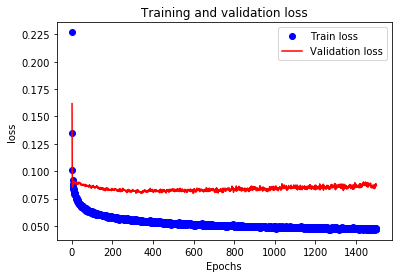

In [20]:
history = model.history.history
plot_epochs_graph(history, 'loss', True)

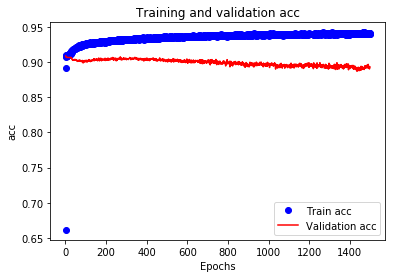

In [21]:
plot_epochs_graph(history, 'acc', True)

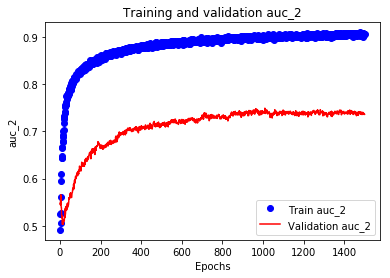

In [22]:
plot_epochs_graph(history, 'auc_2', True)

In [23]:
y_scores = model.predict(X_test.reshape(y_test.shape[0],1,35))

In [24]:
y_scores = y_scores.flatten()

In [25]:
y_test.shape

(15540,)

In [26]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc=roc_auc_score(y_test, y_scores)
print("AUC {:.3f}".format(auc))

AUC 0.818


In [27]:
mlf_rnn_tracking(experiment_name = expname,
                prefix = prefix_time_seq,
                trainfiles = datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl',
                testfiles = datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl',
                 val_trainfiles = datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl',
                 val_testfiles = datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl',
                indexes_path = datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl',
                train_size = X.shape[0], test_size=X_test.shape[0],
                optimizer=optimizer, batch_size=batch_size, epochs=epochs,
                kernel_initializer=kernel_initializer, 
                early_stopping=False, shuffle=shuffle,
                rnn=model, history=history,
                test_fpr=fpr, test_tpr=tpr, y_scores=y_scores,
                test_auc=auc, history_vals_to_track=['loss', 'auc_2', 'acc', 'val_loss', 'val_auc_2', 'val_acc'])

- Activating existing experiment 'RNNenriched_time_seq24000_6000__p180', the following results will be saved in it...
- Tracking the experiment on mlflow...


Using TensorFlow backend.


- Experiment tracked.


In [28]:
save_tf_model(model, "../data/models/"+expname+"/", model.get_config()['name'], prefix_time_seq)

Saving model to ../data/models/RNNenriched_time_seq24000_6000__p180/time_2018-02-20_p180_bg__sequential_19095_756.h5


('time_2018-02-20_p180_bg__sequential_19095_756.h5',
 '../data/models/RNNenriched_time_seq24000_6000__p180/time_2018-02-20_p180_bg__sequential_19095_756.h5')